# Eye for Blind – Image Captioning with Attention

# 1. Objective

Eye for Blind: An Assistive Image Captioning System with Visual Attention

This project implements a deep learning model that generates natural language descriptions of images, particularly aimed at visually impaired users. The model leverages an attention mechanism to selectively focus on image regions when generating each word, mimicking human vision.

Inspired by "Show, Attend and Tell" (Xu et al., 2015), this implementation:
1. Uses a CNN encoder (InceptionV3) to extract image features.
2. Applies additive (Bahdanau) attention during decoding.
3. Employs a decoder LSTM to generate captions.
4. Converts generated captions to speech using gTTS.

In [1]:
import os
import re
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
from typing import Dict, List, Tuple, Optional, Any
import tensorflow as tf #type: ignore
from tensorflow.keras import layers, Model #type: ignore
from tensorflow.keras.optimizers.schedules import CosineDecay #type: ignore
from tensorflow.keras.losses import SparseCategoricalCrossentropy #type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer #type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences #type: ignore
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction #type: ignore
from gtts import gTTS #type: ignore
from IPython.display import Audio, display
import tqdm

2025-06-19 16:02:49.239269: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Configuration - Optimized for RTX 6000 Ada
CONFIG = {
    'image_dir': '/home/flickr30k_images/flickr30k_images',
    'caption_file': '/home/flickr30k_images/flickr30k_images/results.csv',
    'batch_size': 64,  # Reduced from 128 for single GPU
    'buffer_size': 31783,
    'max_length': 30,
    'embedding_dim': 512,
    'units': 512,
    'seed': 42,
    'epochs': 15,
    'patience': 4,
    'learning_rate': 1e-3,
    'grad_clip_value': 5.0,
    'vocab_min_count': 5,
    'checkpoint_dir': './checkpoints',
    'mixed_precision': True,  # Keep enabled for RTX 6000 Ada
}

# Set random seeds for reproducibility
tf.random.set_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
random.seed(CONFIG['seed'])

# Mixed precision policy - RTX 6000 Ada has excellent mixed precision support
if CONFIG['mixed_precision']:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled for RTX 6000 Ada")

# Single GPU setup
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    # Enable memory growth for RTX 6000 Ada
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
    
    # Use default strategy for single GPU
    strategy = tf.distribute.get_strategy()
    print(f"Using single GPU: {physical_devices[0].name}, batch size={CONFIG['batch_size']}")
else:
    print("No GPUs found, using CPU")
    strategy = tf.distribute.get_strategy()

# Constants
AUTOTUNE = tf.data.AUTOTUNE

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA RTX 6000 Ada Generation, compute capability 8.9
Mixed precision enabled for RTX 6000 Ada
Using single GPU: /physical_device:GPU:0, batch size=64


2025-06-19 16:02:51.080178: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-19 16:02:51.089373: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-19 16:02:51.090779: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-19 16:02:51.092567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
class DataProcessor:
    def __init__(self, config):
        self.config = config
        self.captions_dict = dict()
        self.tokenizer = None
        self.vocab_size = 0
        self.train_data = []
        self.val_data = []
        self.test_data = []
    
    def load_captions(self) -> Dict[str, List[str]]:
        """Load and convert pipe-delimited Flickr-style caption file to a dict."""
        print(f"Loading captions from {self.config['caption_file']}")
        df = pd.read_csv(self.config['caption_file'], sep='|', header=None, 
                         names=['image_name', 'comment_number', 'comment'], engine='python')
        df['image_name'] = df['image_name'].str.strip()
        df['comment'] = df['comment'].str.strip()
        
        caption_map = {}
        for img, group in df.groupby('image_name'):
            caption_map[img] = group['comment'].tolist()
        
        self.captions_dict = caption_map
        print(f"Loaded {len(caption_map)} images with captions")
        return caption_map
    
    def display_samples(self, num_samples: int = 3):
        """Display sample images with their captions."""
        if self.captions_dict is None:
            self.load_captions()
        
        sample_keys = random.sample(list(self.captions_dict.keys()), num_samples)
        for key in sample_keys:
            img_path = os.path.join(self.config['image_dir'], key)
            img = Image.open(img_path)
            plt.figure(figsize=(8, 6))
            plt.imshow(img)
            plt.axis('off')
            plt.title(key)
            plt.show()
            for cap in self.captions_dict[key][:5]: #type: ignore
                print(f"- {cap}")
            print()
    
    def preprocess_caption(self, caption: str) -> Optional[str]:
        """Clean and format caption text."""
        if caption is None or not isinstance(caption, str):
            return None
        caption = caption.lower()
        caption = re.sub(r"[^a-z0-9.,? ]", "", caption)
        return f"<start> {caption.strip()} <end>"
    
    def prepare_captions(self):
        """Process all captions and create vocabulary."""
        if self.captions_dict is None:
            self.load_captions()
        
        print("Preprocessing captions...")
        # Prepare captions and vocabulary
        all_captions = []
        for caps in self.captions_dict.values():
            for c in caps:
                p = self.preprocess_caption(c)
                if p:
                    all_captions.append(p)
        
        print(f"Total captions: {len(all_captions)}")
        word_counts = Counter(word for cap in all_captions for word in cap.split())
        valid_words = {word for word, count in word_counts.items() 
                      if count >= self.config['vocab_min_count']}
        
        # Filter captions by valid words
        def keep_caption(caption: str) -> bool:
            words = caption.split()
            return all(w in valid_words or w in ('<start>', '<end>') for w in words)
        
        filtered_captions = [c for c in all_captions if keep_caption(c)]
        print(f"Filtered captions: {len(filtered_captions)}")
        
        # Create tokenizer
        print("Building tokenizer...")
        tokenizer = Tokenizer(oov_token="<unk>")
        tokenizer.fit_on_texts(filtered_captions)
        
        # Ensure special tokens are in the vocabulary
        special_tokens = ['<start>', '<end>']
        for token in special_tokens:
            if token not in tokenizer.word_index:
                new_index = len(tokenizer.word_index) + 1
                tokenizer.word_index[token] = new_index
                tokenizer.index_word[new_index] = token
        
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer.word_index) + 1
        print(f"Vocabulary size: {self.vocab_size}")
        
        # Create image-caption pairs
        print("Creating image-caption pairs...")
        image_caption_pairs = []
        for img, caps in self.captions_dict.items():
            for c in caps:
                p = self.preprocess_caption(c)
                if p and keep_caption(p):
                    image_caption_pairs.append((img, p))
        
        # Create train/val/test splits
        random.shuffle(image_caption_pairs)
        num_total = len(image_caption_pairs)
        train_split = int(0.8 * num_total)
        val_split = int(0.9 * num_total)
        self.train_data = image_caption_pairs[:train_split]
        self.val_data = image_caption_pairs[train_split:val_split]
        self.test_data = image_caption_pairs[val_split:]
        
        print(f"Dataset split: Train={len(self.train_data)}, Val={len(self.val_data)}, Test={len(self.test_data)}")
        return filtered_captions
    
    def encode_caption(self, caption: str) -> Tuple[np.ndarray, int]:
        """Convert caption text to sequence of token ids."""
        if self.tokenizer is None:
            raise ValueError("Tokenizer not initialized. Call prepare_captions first.")
        
        seq = self.tokenizer.texts_to_sequences([caption])[0]
        padded_seq = pad_sequences([seq], maxlen=self.config['max_length'], padding='post')[0]
        return padded_seq, len(seq)
    
    @tf.function(reduce_retracing=True)
    def load_image(self, path: str) -> tf.Tensor:
        """Load and preprocess an image efficiently in graph mode."""
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, dtype=tf.float32)
        img = tf.image.resize(img, [299, 299])
        img = tf.ensure_shape(img, [299, 299, 3])
        return tf.keras.applications.inception_v3.preprocess_input(img)

    def data_generator(self, data):
        """Generator function for dataset creation."""
        for img, cap in data:
            img_path = os.path.join(self.config['image_dir'], img)
            img_tensor = self.load_image(img_path)
            token_ids, cap_len = self.encode_caption(cap)
            yield img_tensor, token_ids, cap_len
    
    def build_dataset(self, data, shuffle=True, cache=True):
        """Create a tf.data.Dataset optimized for single GPU."""
        output_signature = (
            tf.TensorSpec((299, 299, 3), tf.float32),
            tf.TensorSpec((CONFIG['max_length'],), tf.int32),
            tf.TensorSpec((), tf.int32)
        )

        ds = tf.data.Dataset.from_generator(
            lambda: self.data_generator(data),
            output_signature=output_signature
        )

        if cache:
            ds = ds.cache()
        if shuffle:
            ds = ds.shuffle(CONFIG['buffer_size'])

        ds = ds.batch(CONFIG['batch_size'])
        ds = ds.prefetch(AUTOTUNE)
        return ds

    def prepare_datasets(self, small_subset=False):
        """Prepare all datasets for training/validation/testing."""
        if not self.train_data:
            self.prepare_captions()
        
        if small_subset:
            # Use 10% of each dataset
            train_subset = self.train_data[:int(len(self.train_data) * 0.1)]
            val_subset = self.val_data[:int(len(self.val_data) * 0.1)]
            test_subset = self.test_data[:int(len(self.test_data) * 0.1)]
            print(f"Using small subset: Train={len(train_subset)}, Val={len(val_subset)}, Test={len(test_subset)}")
        else:
            train_subset = self.train_data
            val_subset = self.val_data
            test_subset = self.test_data
        
        print("Building datasets...")
        train_ds = self.build_dataset(train_subset)
        val_ds = self.build_dataset(val_subset)
        test_ds = self.build_dataset(test_subset, shuffle=False)
        
        return train_ds, val_ds, test_ds

In [4]:
class Encoder(Model):
    def __init__(self):
        super().__init__(name="encoder")
        # Use efficient model loading with feature extraction only
        base = tf.keras.applications.InceptionV3(
            include_top=False, 
            weights='imagenet',
            input_shape=(299, 299, 3)
        )
        base.trainable = False
        # Use specific layer for feature extraction
        output_layer = base.get_layer('mixed10').output
        self.cnn = Model(inputs=base.input, outputs=output_layer)
        self.reshape = layers.Reshape((-1, 2048))
    
    def call(self, x):
        x = self.cnn(x)
        return self.reshape(x)


class BahdanauAttention(layers.Layer):
    def __init__(self, units):
        super().__init__(name="attention")
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
    
    def call(self, features, hidden):
        hidden_time = tf.expand_dims(hidden, 1)
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_time)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = tf.reduce_sum(attention_weights * features, axis=1)
        return context_vector, tf.squeeze(attention_weights, -1)

class Decoder(Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super().__init__(name="decoder")
        self.units = units
        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.lstm = layers.LSTM(units, return_sequences=True, return_state=True)
        self.fc = layers.Dense(vocab_size)
        self.attention = BahdanauAttention(units)
        self.dropout = layers.Dropout(0.3)
    
    def call(self, x, features, hidden, cell):
        context, attn = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context, 1), x], axis=-1)
        output, state_h, state_c = self.lstm(x, initial_state=[hidden, cell])
        output = self.dropout(output)
        logits = self.fc(output)
        return logits, state_h, state_c, attn

In [5]:
class ImageCaptioningModel:
    def __init__(self, config, processor):
        self.config = config
        self.processor = processor
        self.encoder = None
        self.decoder = None
        self.optimizer = None
        self.loss_fn = None
        self.ckpt_manager = None
        self.best_bleu = 0
        self.train_loss_log = []
        self.val_bleu_log = []
        self.smoothie = SmoothingFunction().method4
    
    def build_model(self):
        """Build model for single GPU - no distribution strategy needed."""
        print("Building model for single GPU...")
        self.encoder = Encoder()
        self.decoder = Decoder(
            embedding_dim=self.config['embedding_dim'], 
            units=self.config['units'], 
            vocab_size=self.processor.vocab_size
        )
        
        lr_schedule = CosineDecay(
            initial_learning_rate=self.config['learning_rate'],
            decay_steps=10000
        )
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        self.loss_fn = SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        
        # Set up checkpointing
        ckpt_dir = self.config['checkpoint_dir']
        os.makedirs(ckpt_dir, exist_ok=True)
        ckpt = tf.train.Checkpoint(
            encoder=self.encoder, 
            decoder=self.decoder, 
            optimizer=self.optimizer
        )
        self.ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_dir, max_to_keep=3)
        
        # Try to restore the latest checkpoint
        if self.ckpt_manager.latest_checkpoint:
            ckpt.restore(self.ckpt_manager.latest_checkpoint)
            print(f"Restored from checkpoint: {self.ckpt_manager.latest_checkpoint}")
    
    @tf.function
    def train_step(self, img_tensor, target, cap_len):
        """Execute a single training step."""
        loss = 0.0
        batch_size = tf.shape(img_tensor)[0]
        hidden = tf.zeros((batch_size, self.config['units']))
        cell = tf.zeros_like(hidden)
        dec_input = tf.expand_dims(
            tf.repeat(self.processor.tokenizer.word_index['<start>'], batch_size), 1
        )
        
        with tf.GradientTape() as tape:
            features = self.encoder(img_tensor)
            for t in range(1, self.config['max_length']):
                logits, hidden, cell, _ = self.decoder(dec_input, features, hidden, cell)
                loss_ = self.loss_fn(target[:, t], tf.squeeze(logits, 1))
                mask = tf.cast(target[:, t] > 0, tf.float32)
                loss += tf.reduce_sum(loss_ * mask)
                dec_input = tf.expand_dims(target[:, t], 1)
            
            # Average loss per token
            total_loss = loss / tf.reduce_sum(tf.cast(cap_len, tf.float32))
        
        # Get trainable variables and apply gradients
        variables = self.encoder.trainable_variables + self.decoder.trainable_variables
        gradients = tape.gradient(total_loss, variables)
        
        # Clip gradients to prevent exploding gradients
        clipped_gradients, _ = tf.clip_by_global_norm(gradients, self.config['grad_clip_value'])
        self.optimizer.apply_gradients(zip(clipped_gradients, variables))
        
        return total_loss
    
    def greedy_decode(self, image_path: str, return_attention=False):
        """Generate a caption for an image using greedy decoding."""
        img_tensor = tf.expand_dims(self.processor.load_image(image_path), 0)
        features = self.encoder(img_tensor)
        hidden = tf.zeros((1, self.config['units']))
        cell = tf.zeros_like(hidden)
        dec_input = tf.expand_dims([self.processor.tokenizer.word_index['<start>']], 0)
        
        result, alphas = [], []
        
        for _ in range(self.config['max_length']):
            logits, hidden, cell, alpha = self.decoder(dec_input, features, hidden, cell)
            predicted_id = tf.argmax(logits[0, 0]).numpy()
            
            word = self.processor.tokenizer.index_word.get(predicted_id, '')
            if word == '<end>': 
                break
                
            if word not in ('<start>', '<unk>'):
                result.append(word)
                
            alphas.append(alpha[0].numpy())
            dec_input = tf.expand_dims([predicted_id], 0)
        
        return (result, alphas) if return_attention else result
    
    def evaluate_bleu(self, test_data, max_samples=None):
        """Calculate BLEU scores on test data."""
        refs, hyps = [], []
        data_to_eval = test_data[:max_samples] if max_samples else test_data
        
        for img_name, _ in tqdm.tqdm(data_to_eval):
            image_path = os.path.join(self.config['image_dir'], img_name)
            hyp = self.greedy_decode(image_path)
            
            # Process ground truth captions
            gt = [self.processor.preprocess_caption(c).split() for c in self.processor.captions_dict[img_name][:5]]
            gt = [[w for w in cap if w not in ('<start>', '<end>')] for cap in gt]
            
            refs.append(gt)
            hyps.append(hyp)
        
        # Calculate BLEU scores for different n-grams
        bleu_scores = {}
        for i in range(1, 5):
            weights = tuple([1.0/i]*i + [0.0]*(4-i))
            score = corpus_bleu(refs, hyps, weights=weights, smoothing_function=self.smoothie)
            bleu_scores[f'bleu-{i}'] = score
            print(f"BLEU-{i}: {score:.4f}")
        
        return bleu_scores
    
    def train(self, train_ds, val_data, epochs=None):
        """Train the model with early stopping."""
        if epochs is None:
            epochs = self.config['epochs']
        
        patience = self.config['patience']
        wait = 0
        
        for epoch in range(epochs):
            start = time.time()
            total_loss = 0.0
            step = 0
            
            # Training loop
            print(f"Epoch {epoch+1}/{epochs}")
            progbar = tf.keras.utils.Progbar(
                target=None,
                stateful_metrics=['loss']
            )
            
            for batch, (img_tensor, target, cap_len) in enumerate(train_ds):
                if batch == 0 and progbar.target is None:
                    progbar.target = len(self.processor.train_data) // self.config['batch_size'] + 1
                
                batch_loss = self.train_step(img_tensor, target, cap_len)
                total_loss += batch_loss
                progbar.update(batch + 1, values=[('loss', batch_loss)])
                step += 1
            
            # Average loss for the epoch
            avg_loss = total_loss / step
            self.train_loss_log.append(float(avg_loss))
            
            # Save checkpoint
            self.ckpt_manager.save()
            
            # Validation on a subset for speed
            print("Evaluating on validation subset...")
            validation_subset = val_data[:100]
            bleu_scores = self.evaluate_bleu(validation_subset)
            bleu4 = bleu_scores['bleu-4']
            self.val_bleu_log.append(bleu4)
            
            # Early stopping logic
            if bleu4 > self.best_bleu:
                self.best_bleu = bleu4
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    print(f"Early stopping triggered at epoch {epoch+1}")
                    break
            
            print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, BLEU-4 = {bleu4:.4f}, Time = {time.time()-start:.2f}s", flush=True)
        
        return self.train_loss_log, self.val_bleu_log
    
    def plot_attention(self, image_path: str, caption: list, alphas: list):
        """Visualize attention weights overlaid on the source image."""
        img = np.array(Image.open(image_path).resize((224, 224)))
        fig = plt.figure(figsize=(15, 8))
        
        for t in range(len(caption)):
            ax = fig.add_subplot(3, int(np.ceil(len(caption)/3)), t+1)
            ax.set_title(caption[t])
            ax.imshow(img)
            
            alpha = np.array(alphas[t])
            attention_shape = int(np.sqrt(alpha.size))
            alpha = alpha.reshape(attention_shape, attention_shape)
            ax.imshow(alpha, cmap='viridis', alpha=0.6, extent=(0, 224, 224, 0))
            ax.axis('off')
            
        plt.tight_layout()
        plt.show()
    
    def plot_history(self):
        """Plot training history."""
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss_log, label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.plot(self.val_bleu_log, label='Val BLEU-4')
        plt.xlabel('Epoch')
        plt.ylabel('BLEU-4')
        plt.title('Validation BLEU-4')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def speak_caption(self, caption: str, filename="tts_output.mp3"):
        """Generate speech audio from caption text."""
        if not caption:
            print("Empty caption, nothing to speak")
            return
            
        tts = gTTS(text=caption, lang='en')
        tts.save(filename)
        display(Audio(filename))
        print(f"Audio saved to {filename}")
    
    def demo(self, image_path):
        """Run a full demonstration of the model."""
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            return
            
        print(f"Generating caption for: {image_path}")
        
        # Display the image
        img = Image.open(image_path)
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        
        # Generate caption with attention
        words, attention = self.greedy_decode(image_path, return_attention=True)
        caption = " ".join(words)
        print(f"Generated caption: {caption}")
        
        # Plot attention
        self.plot_attention(image_path, words, attention)
        
        # Generate speech
        self.speak_caption(caption)
        
        return caption


In [6]:
# Initialize processor and load data
processor = DataProcessor(CONFIG)

In [7]:
processor.load_captions()

Loading captions from /home/flickr30k_images/flickr30k_images/results.csv
Loaded 31784 images with captions


{'1000092795.jpg': ['Two young guys with shaggy hair look at their hands while hanging out in the yard .',
  'Two young , White males are outside near many bushes .',
  'Two men in green shirts are standing in a yard .',
  'A man in a blue shirt standing in a garden .',
  'Two friends enjoy time spent together .'],
 '10002456.jpg': ['Several men in hard hats are operating a giant pulley system .',
  'Workers look down from up above on a piece of equipment .',
  'Two men working on a machine wearing hard hats .',
  'Four men on top of a tall structure .',
  'Three men on a large rig .'],
 '1000268201.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A little girl in a pink dress going into a wooden cabin .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl climbing into a wooden playhouse',
  'A girl going into a wooden building .'],
 '1000344755.jpg': ['Someone in a blue shirt and hat is standing on stair and leaning against

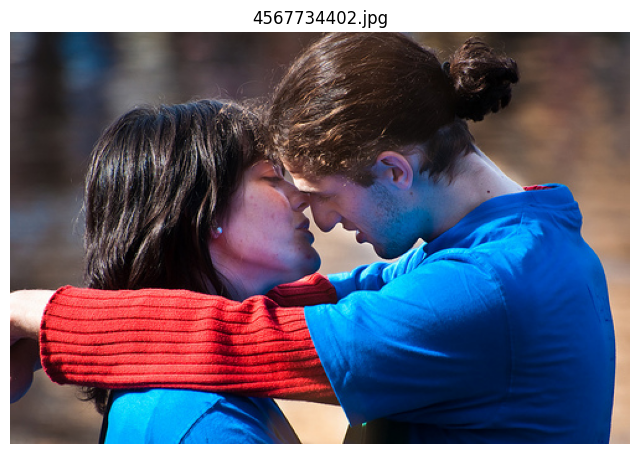

- A man in a blue and red shirt hugs a woman in a blue top .
- A man and a woman are about to kiss .
- A woman and a man getting closer .
- A couple that is about to kiss .
- Two young people are kissing .



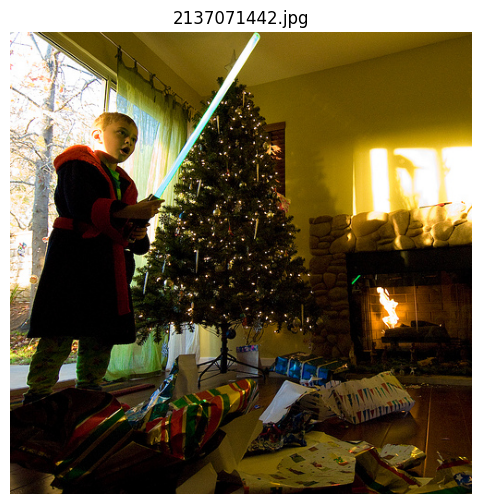

- Young boy holding a light saber in front of a Christmas tree with wrapping paper littering the floor .
- Boy indoors by Christmas tree , playing with green , light-up sword toy .
- A boy holds a light saber in front of a Christmas tree .
- A boy receives a light saber for Christmas .
- A boy looks at a new toy during christmas



In [8]:
processor.display_samples(2)

In [9]:
processor.prepare_captions()

Preprocessing captions...
Total captions: 158915
Filtered captions: 141359
Building tokenizer...
Vocabulary size: 7714
Creating image-caption pairs...
Dataset split: Train=113087, Val=14136, Test=14136


['<start> two young guys with shaggy hair look at their hands while hanging out in the yard . <end>',
 '<start> two young , white males are outside near many bushes . <end>',
 '<start> two men in green shirts are standing in a yard . <end>',
 '<start> a man in a blue shirt standing in a garden . <end>',
 '<start> several men in hard hats are operating a giant pulley system . <end>',
 '<start> workers look down from up above on a piece of equipment . <end>',
 '<start> two men working on a machine wearing hard hats . <end>',
 '<start> four men on top of a tall structure . <end>',
 '<start> three men on a large rig . <end>',
 '<start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> a little girl in a pink dress going into a wooden cabin . <end>',
 '<start> a little girl climbing the stairs to her playhouse . <end>',
 '<start> a little girl climbing into a wooden playhouse <end>',
 '<start> a girl going into a wooden building . <end>',
 '<start> s

In [10]:
# Create datasets
train_ds, val_ds, _ = processor.prepare_datasets(small_subset=True)

Using small subset: Train=11308, Val=1413, Test=1413
Building datasets...


2025-06-19 16:02:56.159354: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-19 16:02:56.162604: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-19 16:02:56.164370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-19 16:02:56.165778: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning

In [11]:
# Build and train model
model = ImageCaptioningModel(CONFIG, processor)
model.build_model()

Building model for single GPU...


In [12]:
# Uncomment to train the model
model.train(train_ds, processor.val_data)

Epoch 1/15


2025-06-19 16:03:08.345262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 367 of 31783
2025-06-19 16:03:18.352801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 699 of 31783
2025-06-19 16:03:28.364396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 991 of 31783
2025-06-19 16:03:38.371229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1273 of 31783
2025-06-19 16:03:48.341770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1528 of 31783
2025-06-19 16:03:58.357418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1767 of 31783
2025-06-19 16:04:08.359876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up 

TypeError: in user code:

    File "/tmp/ipykernel_17654/2795920157.py", line 61, in train_step  *
        logits, hidden, cell, _ = self.decoder(dec_input, features, hidden, cell)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_file11b7_4_h.py", line 13, in tf__call
        (output, state_h, state_c) = ag__.converted_call(ag__.ld(self).lstm, (ag__.ld(x),), dict(initial_state=[ag__.ld(hidden), ag__.ld(cell)]), fscope)

    TypeError: Exception encountered when calling layer "decoder" "                 f"(type Decoder).
    
    in user code:
    
        File "/tmp/ipykernel_17654/1117422186.py", line 49, in call  *
            output, state_h, state_c = self.lstm(x, initial_state=[hidden, cell])
        File "/usr/local/lib/python3.8/dist-packages/keras/layers/rnn/base_rnn.py", line 623, in __call__  **
            return super().__call__(inputs, **kwargs)
        File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
            raise e.with_traceback(filtered_tb) from None
        File "/usr/local/lib/python3.8/dist-packages/keras/backend.py", line 2455, in dot
            out = tf.matmul(x, y)
    
        TypeError: Exception encountered when calling layer "lstm" "                 f"(type LSTM).
        
        Input 'b' of 'MatMul' Op has type float16 that does not match type float32 of argument 'a'.
        
        Call arguments received by layer "lstm" "                 f"(type LSTM):
          • inputs=tf.Tensor(shape=(64, 1, 2560), dtype=float16)
          • mask=None
          • training=False
          • initial_state=['tf.Tensor(shape=(64, 512), dtype=float32)', 'tf.Tensor(shape=(64, 512), dtype=float32)']
    
    
    Call arguments received by layer "decoder" "                 f"(type Decoder):
      • x=tf.Tensor(shape=(64, 1), dtype=int32)
      • features=tf.Tensor(shape=(64, 64, 2048), dtype=float16)
      • hidden=tf.Tensor(shape=(64, 512), dtype=float32)
      • cell=tf.Tensor(shape=(64, 512), dtype=float32)


In [ ]:
model.plot_history()

In [ ]:
# Evaluate on test set
print("Evaluating on test set:")
model.evaluate_bleu(processor.test_data[:20])

In [ ]:
# Demo with a sample image
sample_img = os.path.join(CONFIG['image_dir'], processor.test_data[0][0])
model.demo(sample_img)